In [1]:
import pandas as pd
import numpy as np

import os
from os.path import join as opj
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
from PIL import Image
import zipfile

import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import albumentations as albu
import timm
import tqdm

In [2]:
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [3]:
img_size = 512
BATCH_SIZE =4
weights = 'imagenet'
learning_rate = 1e-3
EPOCHS = 10
dropout_rate = 0.2
NUM_WORKERS = 1
PATH = './model_param/'

In [4]:
train_inp_files = glob(f'./data/train_input_img_{img_size}/*.png')
train_targ_files = glob(f'./data/train_label_img_{img_size}/*.png')

val_inp_files = glob(f'./data/val_input_img_{img_size}/*.png')
val_targ_files = glob(f'./data/val_label_img_{img_size}/*.png')

In [5]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)


In [6]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files)

(11620, 2100, 11620, 2100)

In [7]:
x_img = np.array(Image.open(train_inp_files[1030]))
y_img = np.array(Image.open(train_targ_files[1030]))

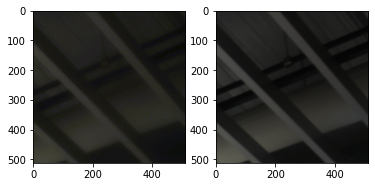

In [8]:
plt.subplot(1,2,1)
plt.imshow(x_img)
plt.subplot(1,2,2)
plt.imshow(y_img)
plt.show()

In [9]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, x_transforms=None, common_transforms=None):
        super().__init__()
        self.x_transforms = x_transforms
        self.common_transforms = common_transforms
        self.x_data = x
        self.y_data = y
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        x = np.array(Image.open(x))
        y = np.array(Image.open(y))

        if self.x_transforms is not None:
            x_transformed = self.x_transforms(image=x)
            x = x_transformed['image']
        
        if self.common_transforms is not None:
            transformed = self.common_transforms(image=x, target_image=y)
            x = transformed['image']
            y = transformed['target_image']
        
        x = Image.fromarray(x)
        y = Image.fromarray(y)

        totensor = T.ToTensor()
        x = totensor(x)
        y = totensor(y)

        return x, y

In [10]:
common_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.Cutout(num_holes=8, max_h_size=50, max_w_size=50, p=1.)
    ],
    additional_targets={'target_image':'image'})

x_transform = albu.Compose([
    albu.Posterize(p=1.),
])

/home/seungjae41/comp/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [11]:
dataset = CustomImageDataset(x=train_inp_files,
                       y=train_targ_files,
                       x_transforms=x_transform,
                       common_transforms=common_transform)

In [12]:
x, y = dataset.__getitem__(100)

In [13]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max = 1.0):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score
    
def calc_psnr(img1, img2):
    if torch.equal(img1, img2):
        return 100
    else:
        mse = torch.mean((img1-img2)**2)
    return 10 * torch.log10(1/mse)

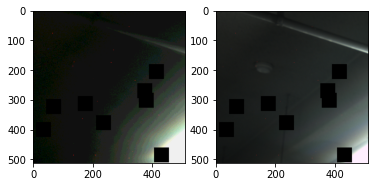

In [14]:
toPIL = T.ToPILImage()
x = toPIL(x)
y = toPIL(y)
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)
plt.show()

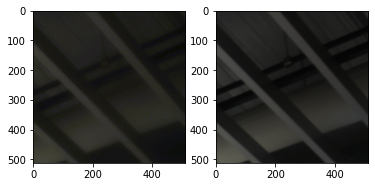

In [15]:
plt.subplot(1,2,1)
plt.imshow(x_img)
plt.subplot(1,2,2)
plt.imshow(y_img)
plt.show()

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, normalization=True):
            block = [nn.Conv2d(in_channels, out_channels, 4, 2, 1)]
            if normalization:
                block.append(nn.InstanceNorm2d(out_channels))
            block.append(nn.LeakyReLU(0.2))
            return block
        
        self.discriminator = nn.Sequential(
            *discriminator_block(in_channels*2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)            
        )
        
    def forward(self, condition, gt):
        x = torch.cat([condition, gt], axis=1)
        return self.discriminator(x)

In [17]:
in_dim = 3
out_dim = 3
num_filters = 64
num_epoch = 3000
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
res ={
    'train_psnr':[],
    'val_psnr':[],
}

In [19]:
def train(G_model, D_model, train_data,val_data, criterion_mse, criterion_L1, optimizer_G, optimizer_D, scheduler=None):
    best_psnr = 0
    #G_model = nn.DataParallel(G_model)
    #D_model = nn.DataParallel(D_model)
    real_label = Variable(torch.ones(BATCH_SIZE, 1, 256 // 16, 256 // 16), requires_grad=False).cuda()
    gene_label = Variable(torch.zeros(BATCH_SIZE, 1, 256 // 16, 256 // 16), requires_grad=False).cuda()
    scaler = GradScaler()
    
    for epoch in range(EPOCHS):
        G_model.train()
        D_model.train()
        train_running_step = len(train_data)
        print(f'running step: {train_running_step}')
        avg_psnr = 0.0
        idx = 0
        for image, target in tqdm.tqdm(train_data, total=len(train_data)):
            
            #print(image.shape)
            image = image.to(device)
            target = target.to(device)

            optimizer_G.zero_grad()
            optimizer_D.zero_grad()
            
            
            recons = G_model(image)
            #print('recons: ',recons.shape)
            gene_preds = D_model(recons, target)
            G_pixel_loss_ = criterion_mse(target, recons)
            G_adv_loss_ = criterion_L1(gene_preds, real_label)
            G_loss_ = G_adv_loss_+G_pixel_loss_*100

            real_preds = D_model(image, target)
            gene_preds = D_model(recons.detach(), target)
            D_real_loss_=criterion_L1(real_preds, real_label)
            D_gene_loss_ = criterion_L1(gene_preds, gene_label)
            D_loss_ = (D_real_loss_ + D_gene_loss_) / 2

            G_loss_.backward()
            D_loss_.backward()
            optimizer_G.step()
            optimizer_D.step()

            if idx % int(train_running_step/10) == 0:
                print(f'[{epoch}/{EPOCHS}], G_Loss: {G_loss_.item()}, D_loss: {D_loss_.item()}')
            idx+=1
        if scheduler:
            scheduler.step()
        
        val_running_step = len(val_data)
        print(f'running step: {val_running_step}')
        avg_psnr = 0.0
        idx = 0
        G_model.eval()
        D_model.eval()
        with torch.no_grad():
            for img, tgt in tqdm.tqdm(val_data, total=len(val_data)):
                img = img.cuda()
                tgt = tgt.cuda()

                with autocast():
                    recons = G_model(img)
                psnr_ = calc_psnr(recons, tgt)
                avg_psnr += psnr_.item()
                
    
            val_psnr = avg_psnr/val_running_step
            print(f'\t Current valid PSNR | BEST PSNR: [{val_psnr}| {best_psnr}]')

            if val_psnr > best_psnr:
                print(print(f'\t Best PSNR changed [{best_psnr} ---> {val_psnr}]'))
                G_state_dict = {"G_state_dict":G_model.state_dict(),
                                "optimizer_G":optimizer_G.state_dict(),
                                "epoch": epoch}
                D_state_dict = {"D_state_dict":D_model.state_dict(),
                                "optimizer_D":optimizer_D.state_dict(),
                                "eopch":epoch} 
                torch.save(G_state_dict, f'./GD_param/G_{epoch}_{best_psnr}.pth')
                torch.save(D_state_dict, f'./GD_param/D_{epoch}_{best_psnr}.pth')
                
                best_psnr = val_psnr

In [20]:
import effunet.effunet as eff_
G_model = eff_.EffUNet(model='b3', out_channels=3, dropout=0.2, freeze_backbone=False,device='cpu').to(device)
D_model = Discriminator().to(device)

Loaded pretrained weights for efficientnet-b3


In [21]:
#model = UnetGenerator(in_dim=in_dim, out_dim=out_dim, num_filter=num_filters).to(device)
optimizer = torch.optim.Adam(G_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D_model.parameters(), lr=1e-4, betas=(0.5, 0.999))
criterion = torch.nn.MSELoss()
criterion_L1 = nn.L1Loss()
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)

In [22]:
train_dataset = CustomImageDataset(x=train_inp_files,
                       y=train_targ_files,
                       x_transforms=x_transform,
                       common_transforms=common_transform)
valid_dataset = CustomImageDataset(x=val_inp_files,
                        y=val_targ_files,
                        )

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [23]:
train(
    G_model=G_model, 
    D_model=D_model, 
    train_data =train_dataloader, 
    val_data=valid_dataloader, 
    criterion_mse=criterion,criterion_L1=criterion_L1, 
    optimizer_G=optimizer, 
    optimizer_D=optimizer_D)

running step: 2905


  0%|          | 0/2905 [00:00<?, ?it/s]/home/seungjae41/comp/lib/python3.6/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([4, 1, 16, 16])) that is different to the input size (torch.Size([4, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
  0%|          | 0/2905 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 3

In [ ]:
import effunet.effunet as eff_
val_model = eff_.EffUNet(model='b3', out_channels=3, dropout=0.2, freeze_backbone=False,device='cpu')

Loaded pretrained weights for efficientnet-b3


In [ ]:
val_model.load_state_dict(torch.load('./model_param/b3_1_23.667370253072356_256.pth'))

<All keys matched successfully>

In [ ]:
test_img= test_img.reshape(1,3,256,256)

In [ ]:
def predict(img_paths, stride=32, batch_size = 16):
    results = []
    for img_path in img_paths:
        
        img = np.array(Image.open(img_path))
        
        crop = []
        position = []
        batch_count = 0

        result_img = np.zeros_like(img)
        voting_mask = np.zeros_like(img)

        for top in tqdm.tqdm(range(0, img.shape[0], stride)):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                temp = img[top:top+img_size, left:left+img_size, :]
                piece[:temp.shape[0],:temp.shape[1],:]=temp
                crop.append(piece)
                position.append([top,left])
                batch_count += 1
                if batch_count == batch_size:    
                    for i in range(len(crop)):
                        tot = T.ToTensor()
                        crop[i] = Image.fromarray(crop[i])
                        crop[i] = np.array(tot(crop[i]))
                    crop = torch.Tensor(crop)
                    
                    pred = val_model(crop)
                    crop = []
                    batch_count = 0
                    for num, (t, l) in enumerate(position):
                        piece = pred[num]
                        piece = piece.detach().numpy()
                        print(piece)
                        h, w, c = result_img[t:t+img_size, l:l+img_size, :].shape
                        print(h,w,c)
                        result_img[t:t+img_size, l:l+img_size, :] += piece[:h, :w]
                        voting_mask[t:t+img_size, l:l+img_size, :] += 1
                    position = []
        result_img = result_img/voting_mask
        result_img = result_img.astype(np.uint8)
        results.append(result_img)

    return results

In [ ]:
test_inp_files = glob(f'./Data/test/test_input_*.png')
result = predict(test_inp_files[:5],32)

  0%|          | 0/77 [00:03<?, ?it/s]

[[[-7.33836666e-02 -1.77598000e-01 -3.55627984e-01 ... -7.24655986e-01
   -2.46620208e-01 -4.22364324e-01]
  [-2.35189050e-01 -4.69270706e-01  4.12978791e-02 ... -1.01594591e+00
   -7.86939681e-01 -4.24959123e-01]
  [-1.07776083e-01 -4.68735069e-01  5.61896563e-01 ... -1.02160156e-01
   -6.19453132e-01 -5.62582433e-01]
  ...
  [-2.99575210e-01 -5.06077647e-01  6.14892170e-02 ... -3.76966715e-01
   -2.68771023e-01 -4.45620358e-01]
  [-1.59956738e-01 -6.31472945e-01  7.39610791e-02 ... -3.28011543e-01
   -3.40964556e-01 -4.32010770e-01]
  [-2.06417635e-01 -3.98657382e-01 -1.35173231e-01 ...  1.58504955e-02
   -1.07536487e-01 -2.08183348e-01]]

 [[ 4.55579996e-01  5.53135693e-01  7.00606644e-01 ...  6.01476848e-01
    6.07051611e-01  1.45015001e-01]
  [ 5.93711138e-01  8.55694234e-01  7.42884874e-01 ...  6.26167953e-01
    9.10470366e-01  6.23039186e-01]
  [ 5.59564888e-01  5.39752364e-01  6.14443660e-01 ...  8.73248875e-01
    5.24533808e-01  4.95361447e-01]
  ...
  [ 4.53338385e-01  7.2

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float32') to dtype('uint8') with casting rule 'same_kind'